## Process 19F NMR spectra
#### You need:
- The data from the spectrometer
#### You will:
1) Import the 1H Bruker data
2) Use the 1H spectrum to reference
3) Import the 19F Bruker data
    - Optionally sum multiple spectra into a single spectrum
4) Baseline the spectrum by fitting a fourth-order polynomial
5) Fit a Lorentzian function to each peak
6) Produce a plot

Firstly you need to make sure that Python and the required libraries are installed.

To install Python (latest version): 
- Mac https://www.python.org/downloads/macos/
- Windows https://www.python.org/downloads/windows/

To install the libraries type this in your terminal:
`pip install numpy matplotlib scipy nmrglue ipywidgets`

Now you can import the libraries by clicking the arrow to the left of the cell below

In [2]:
# Import libraries
import nmrglue as ng # This is for processing the Bruker data
import matplotlib.pyplot as plt # This is for making the plots
import numpy as np # This is for polynomial fitting
from scipy.optimize import curve_fit # This is for Lorentzian fitting
import ipywidgets as widgets # This is for the interactive parts
from ipywidgets import interact
print("Import OK")

Import OK


If the libraries imported OK, you can proceed.

Now you will import your 1H spectrum for referencing. 
- Locate the NMR data on your computer
- The first experiment, folder `1`, contains the acquisition data
- The data is stored in a file called `fid` with no extension
- Provide the path to folder `1` in the cell below. Do not delete the quotation marks
- Run the cell

To get the path, right-click the folder in Finder/File explorer, then hold Option/Shift and click `Copy pathname`

First step is to reference the 1H spectrum by aligning the DSS peak to 0 ppm. The amount you reference the 1H spectrum by is multiplied by 0.94 to reference the 19F spectrum (ratio of gyromagnetic ratios).

Set the path below to folder 2 of your data from the spectrometer and run the cell:

In [3]:
h_path = "./test_data/multi1/2"

Before referencing the spectrum, you need to Fourier transform (automatic) and phase correct.

Adjust the p0 slider until the DSS peak is symmetrical, then adjust the offset until the DSS peak aligns with the line at 0 ppm.

In [4]:
# Run this cell to read the data

@interact(
    p0=widgets.FloatSlider(min=-70, max=70, step=0.5, value=-25, description="p0", readout_format=".1f"),
    offset=widgets.FloatSlider(min=-0.1, max=0.1, step=0.001, value=0.0, description="Offset", readout_format=".3f")
)
def proc_1h(p0=0, offset=0.0):
    p0_in = p0
    dic, data = ng.bruker.read(h_path)
    data = ng.bruker.remove_digital_filter(dic, data)

    data = ng.proc_base.zf_size(data, 32768)    # zero fill to 32768 points
    data = ng.proc_base.fft(data)               # Fourier transform
    data = ng.proc_base.ps(data, p0=p0_in)      # phase correction
    data = ng.proc_base.di(data)                # discard the imaginaries
    data = ng.proc_base.rev(data) 

    udic = ng.bruker.guess_udic(dic, data)
    uc = ng.fileiobase.uc_from_udic(udic)
    ppm_scale = uc.ppm_scale()
    ppm_scale = uc.ppm_scale() - offset
    plt.figure(figsize=(5, 5))
    plt.plot(ppm_scale, data, color='b')
    plt.xlabel("Chemical Shift (ppm)")
    plt.ylabel("Intensity")
    plt.title("1H NMR Spectrum")
    plt.xlim(-1, 2)
    plt.axvline(x=0, color='green', linestyle='-', linewidth=0.2)
    y_min, y_max = min(data), max(data)
    zoom_factor = 5  # Adjust this to zoom in/out
    plt.ylim(y_min / zoom_factor, y_max / zoom_factor)
    plt.gca().invert_xaxis()



interactive(children=(FloatSlider(value=-25.0, description='p0', max=70.0, min=-70.0, readout_format='.1f', st…

Enter the offset value here and run the cell:

In [5]:
ref_offset = -0.087

Now you will load the 19F data. 

Enter the path to your 19F experiments then enter the numbers of the first and last experiments below then run the cell. If you only have one experiment set the same number for both.

In [6]:
f_path = "./test_data/multi/"
first_exp = 3
last_exp = 38

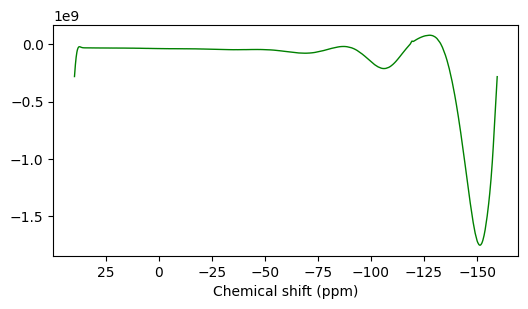

In [10]:
summed_data = None
ppm_scale = None

def read_19f():
    global summed_data, ppm_scale 
    for exp in range(first_exp, last_exp + 1):
        dic, data = ng.bruker.read_pdata(f_path + str(exp) + "/pdata/1")


        if summed_data is None:
            summed_data = data
        else: summed_data += data
        
        if ppm_scale is None:
            udic = ng.bruker.guess_udic(dic, data)
            uc = ng.fileiobase.uc_from_udic(udic)
            ppm_scale = uc.ppm_scale() - ref_offset
    
read_19f()
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(ppm_scale, summed_data, color="green", lw=1)
ax.set_xlabel("Chemical shift (ppm)")
ax.invert_xaxis()
plt.show()

Now you will baseline the data by fitting a polynomial to the region between -55 and -75 ppm, exluding the range with peaks (-60 to -65 ppm). Run the code cell below:

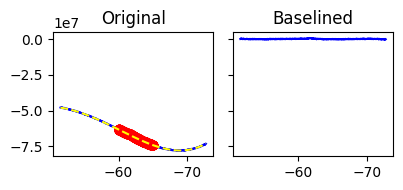

In [12]:
# Baseline
ppm_axis = ppm_scale[30000:37000]
data_axis = summed_data[30000:37000]

# Identify points outside the -60 to -65 ppm range for fitting
mask = (ppm_axis < -60) & (ppm_axis > -65)  # Mask for exclusion

# Baseline selection (only using points outside the exclusion zone)
ppm_baseline = ppm_axis[~mask]
data_baseline = data_axis[~mask]

# Fit a polynomial (degree 3)
degree = 4
coeffs = np.polyfit(ppm_baseline, data_baseline, degree)

# Evaluate baseline fit
baseline_fit = np.polyval(coeffs, ppm_axis)

# Apply baseline correction
corrected_data = data_axis - baseline_fit

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=True)  # Same height, small width

# Left plot: Original data with baseline fit
axes[0].plot(ppm_axis, data_axis, color="blue")
axes[0].plot(ppm_axis[mask], data_axis[mask], 'ro')  # Red points
axes[0].plot(ppm_axis, baseline_fit, '--', color="yellow")
axes[0].set_title("Original")

# Right plot: Baseline-corrected spectrum
axes[1].plot(ppm_axis, corrected_data, color="blue")
axes[1].set_title("Baselined")

axes[1].invert_xaxis()
axes[0].invert_xaxis()

plt.tight_layout()  # Adjust spacing for small figure
plt.show()

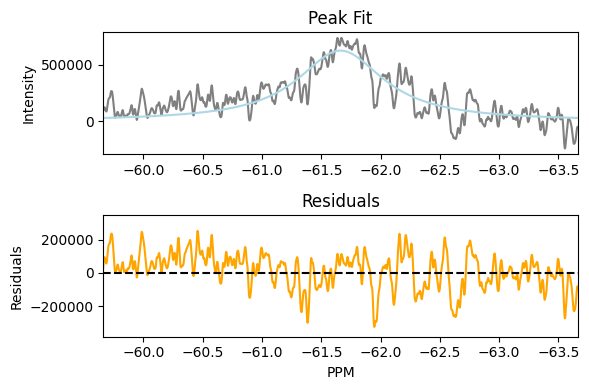

In [14]:
# Define Lorentzian function
def lorentzian(x, A, x0, gamma):
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

# Select a region containing the peak (adjust if necessary)
peak_mask = (ppm_axis > -70) & (ppm_axis < -55)  # Adjust range as needed
ppm_peak = ppm_axis[peak_mask]
data_peak = corrected_data[peak_mask]

# Estimate initial parameters (A, x0, gamma)
A_guess = max(data_peak)  # Peak height
x0_guess = ppm_peak[np.argmax(data_peak)]  # Peak position
gamma_guess = 0.2  # Approximate width, adjust as needed

p0 = [A_guess, x0_guess, gamma_guess]

# Perform curve fitting
popt, _ = curve_fit(lorentzian, ppm_peak, data_peak, p0=p0)

# Extract fitted parameters
A_fit, x0_fit, gamma_fit = popt
lorentzian_fit = lorentzian(ppm_peak, A_fit, x0_fit, gamma_fit)

# Calculate residuals
residuals = data_peak - lorentzian_fit

# Define new x-axis limits
x_min = x0_fit - 2
x_max = x0_fit + 2
zoom_mask = (ppm_axis > x_min) & (ppm_axis < x_max)

# Plot results with residuals below
fig, ax = plt.subplots(figsize=(6, 4), nrows=2, sharex=False)  # Two subplots: one for data, one for residuals

# Plot the main spectrum and fitted curve
ax[0].plot(ppm_axis[zoom_mask], corrected_data[zoom_mask], color="grey")
ax[0].plot(ppm_peak, lorentzian_fit, color="lightblue")  # Fitted peak
ax[0].set_xlim(x_max, x_min)  # Set x-axis limits
ax[0].set_title("Peak Fit")
ax[0].set_ylabel("Intensity")

# Plot residuals
ax[1].plot(ppm_peak, residuals, color="orange", label="Residuals")
ax[1].axhline(0, color="black", linestyle="--")  # Add zero line for reference
ax[1].set_xlabel("PPM")
ax[1].set_xlim(x_max, x_min)
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals")
# plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()